<a href="https://colab.research.google.com/github/Sohankumar6/Final_Project_MRI/blob/main/Final_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


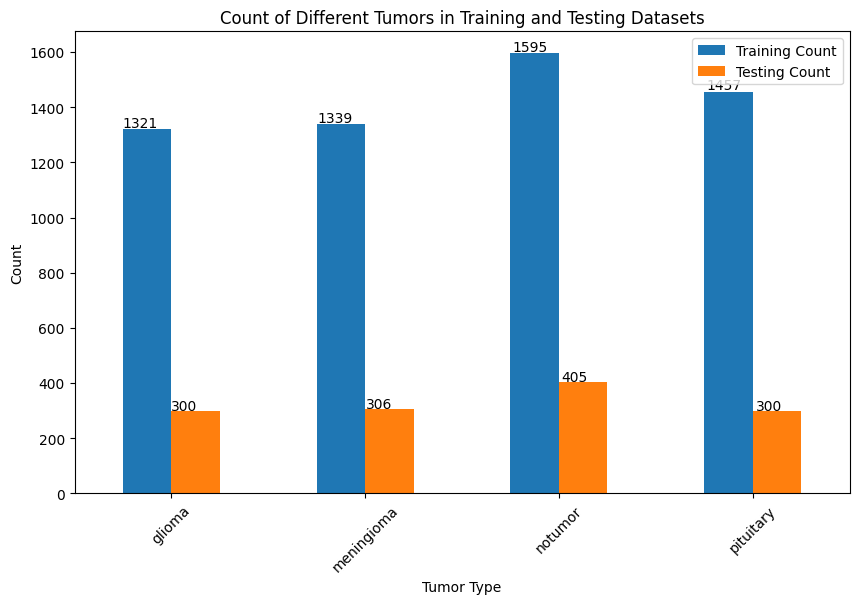

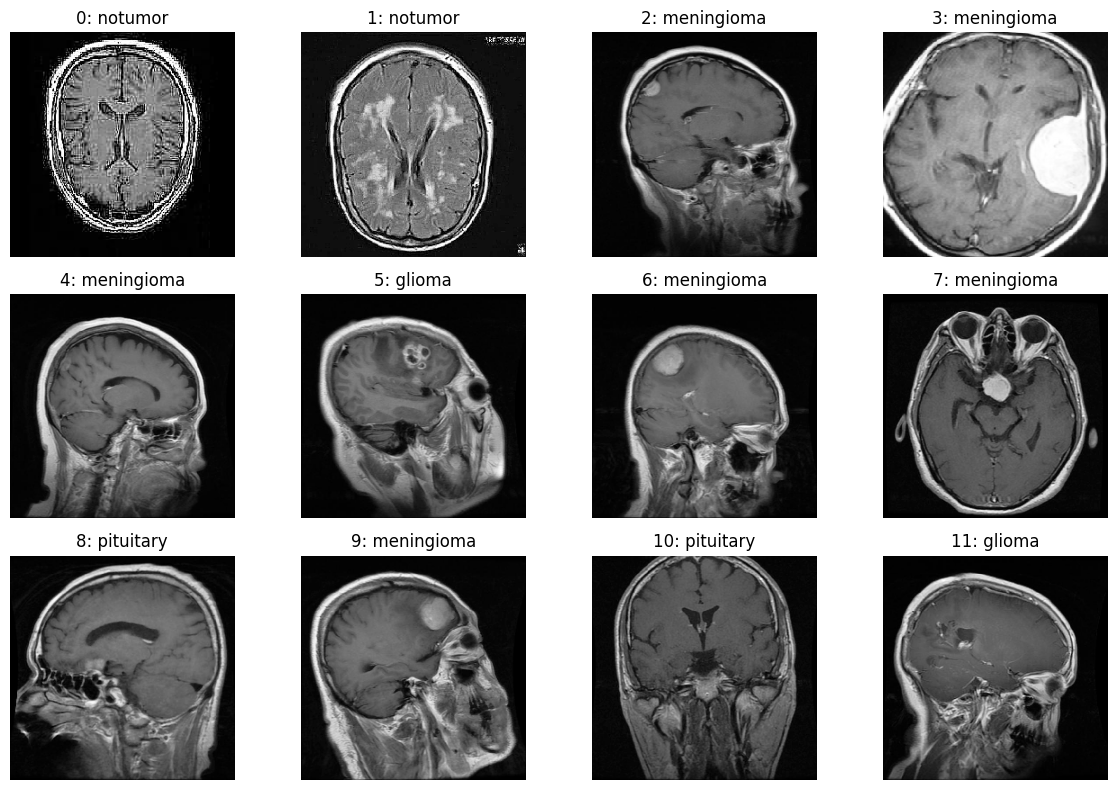

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.7092

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


179/179 [==============================] - 470s 3s/step - loss: 0.7252 - accuracy: 0.7092 - val_loss: 0.6115 - val_accuracy: 0.7811
Epoch 2/50
179/179 [==============================] - 12s 66ms/step - loss: 0.4424 - accuracy: 0.8309 - val_loss: 0.5464 - val_accuracy: 0.8101
Epoch 3/50
179/179 [==============================] - 12s 67ms/step - loss: 0.3272 - accuracy: 0.8745 - val_loss: 0.4827 - val_accuracy: 0.8459
Epoch 4/50
179/179 [==============================] - 12s 65ms/step - loss: 0.2702 - accuracy: 0.8997 - val_loss: 0.3634 - val_accuracy: 0.8619
Epoch 5/50
179/179 [==============================] - 12s 66ms/step - loss: 0.2143 - accuracy: 0.9235 - val_loss: 0.3542 - val_accuracy: 0.8818
Epoch 6/50
179/179 [==============================] - 12s 65ms/step - loss: 0.1762 - accuracy: 0.9364 - val_loss: 0.3172 - val_accuracy: 0.9024
Epoch 7/50
179/179 [==============================] - 12s 63ms/step - loss: 0.1401 - accuracy: 0.9508 - val_loss: 0.3236 - val_accuracy: 0.9047
Epoc

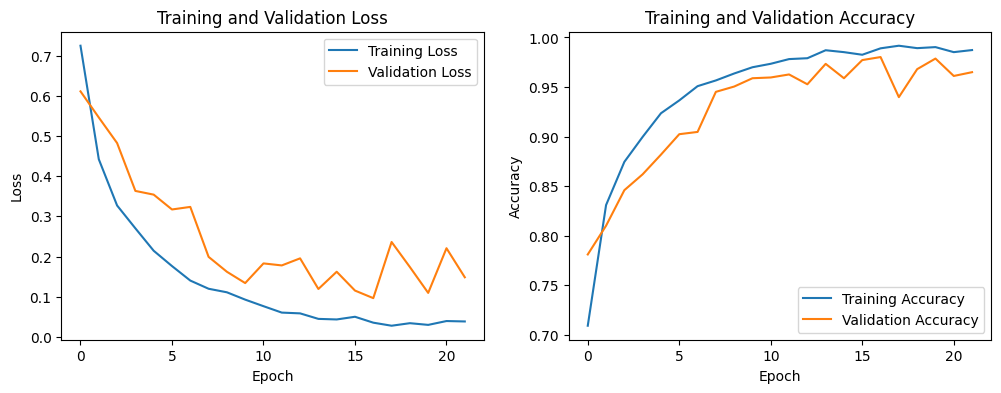

41/41 [==============================] - 2s 38ms/step - loss: 0.0963 - accuracy: 0.9802
Test Loss: 0.09626395255327225
Test Accuracy: 0.980167806148529


In [1]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

# Importing libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential

# Creating a base directory and defining the path
base_directory_path = '/content/drive/MyDrive/Final project'
testing_path = base_directory_path + '/Testing'
training_path = base_directory_path + '/Training'

# Function to count images
def count_and_collect_images(directory_path):
    count_dict = {}
    image_paths = []
    labels = []
    for class_dir in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_dir)
        if os.path.isdir(class_path):
            count_dict[class_dir] = len(os.listdir(class_path))
            for img_name in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_dir)
    return count_dict, image_paths, labels

# Count the number of images in each class for training and testing data
training_counts, training_image_paths, training_labels = count_and_collect_images(training_path)
testing_counts, testing_image_paths, testing_labels = count_and_collect_images(testing_path)

# Converting to dataframe
training_df = pd.DataFrame(list(training_counts.items()), columns=['Tumor Type', 'Training Count'])
testing_df = pd.DataFrame(list(testing_counts.items()), columns=['Tumor Type', 'Testing Count'])

# Merge the training and testing dataframe on tumor type
combined_df = pd.merge(training_df, testing_df, on='Tumor Type')
combined_df.set_index('Tumor Type', inplace=True)

# Plot the counts on a bar graph
ax = combined_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of Different Tumors in Training and Testing Datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

# Creating a class mapping
unique_labels = list(set(training_labels))
class_mappings = {label: idx for idx, label in enumerate(unique_labels)}

# Convert label to indices
training_label_indices = [class_mappings[label] for label in training_labels]
testing_label_indices = [class_mappings[label] for label in testing_labels]

# Function to display images
def show_images(paths, label_indices, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):
    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images or index >= len(paths):
            ax[i].axis('off')
            continue
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_indices[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    for j in range(num_images, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

combined = list(zip(training_image_paths, training_label_indices))
random.shuffle(combined)
training_image_paths, training_label_indices = zip(*combined)
show_images(training_image_paths, training_label_indices, class_mappings, index_list=range(12))

# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Image dimensions
image_dim = (250, 250)

# Function to load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, image_dim)
    return image, label

# Function to preprocess training images
def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

# Function to preprocess testing images
def preprocess_test(image, label):
    return image / 255.0, label

# Convert lists to numpy arrays
training_image_paths = np.array(training_image_paths)
training_label_indices = np.array(training_label_indices)
testing_image_paths = np.array(testing_image_paths)
testing_label_indices = np.array(testing_label_indices)

# Create TensorFlow dataset from image paths and labels
train_ds = tf.data.Dataset.from_tensor_slices((training_image_paths, training_label_indices))
train_ds = train_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_image_paths, testing_label_indices))
test_ds = test_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch datasets
train_ds_preprocessed = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define a simple CNN model
def create_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Model parameters
input_shape = (image_dim[0], image_dim[1], 1)
num_classes = len(class_mappings)

# Create and compile the model
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(train_ds_preprocessed,
                    validation_data=test_ds_preprocessed,
                    epochs=50,
                    callbacks=[early_stopping, checkpoint])

# Plot training and validation loss and accuracy
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

# Plot the training history
plot_history(history)

# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds_preprocessed)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


In [4]:
#save model

model.save('best_model.h5')


In [6]:
loaded_model = tf.keras.models.load_model('best_model.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 128)      